# Perform Analysis - Concepts

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Getting-Prepared" data-toc-modified-id="Getting-Prepared-1">Getting Prepared</a></span></li><li><span><a href="#Chain-raster-functions" data-toc-modified-id="Chain-raster-functions-2">Chain raster functions</a></span></li><li><span><a href="#Visualize-the-workflow-using-draw_graph" data-toc-modified-id="Visualize-the-workflow-using-draw_graph-3">Visualize the workflow using <code>draw_graph</code></a></span></li><li><span><a href="#Use-case---change-detection" data-toc-modified-id="Use-case---change-detection-4">Use case - change detection</a></span><ul class="toc-item"><li><span><a href="#Get-images-of-two-different-times-of-the-same-area" data-toc-modified-id="Get-images-of-two-different-times-of-the-same-area-4.1">Get images of two different times of the same area</a></span></li><li><span><a href="#Obtain-difference-through-map-algebra" data-toc-modified-id="Obtain-difference-through-map-algebra-4.2">Obtain difference through map algebra</a></span></li></ul></li><li><span><a href="#Save-your-result" data-toc-modified-id="Save-your-result-5">Save your result</a></span></li></ul></div>

In this guide, we will first demonstrate how to chain multiple raster functions together, view the workflow as a graph, as well as persist the result. And then show you how to make use of these capabilities in a change detection use case.

## Getting Prepared

Let's first import the packages and make a connection to our GIS.

In [1]:
import arcgis
from arcgis.gis import GIS
from arcgis.raster.functions import *
from IPython.display import display

gis = GIS(url='https://pythonapi.playground.esri.com/portal', username='arcgis_python', password='amazing_arcgis_123')

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri_livingatlas>
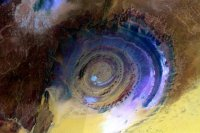

In [9]:
items = gis.content.search("title: Multispectral Landsat", item_type="Imagery Layer",  outside_org=True)
items[0]

In [13]:
l8_lyr = items[0].layers[0]

## Chain raster functions

There are cases where one raster function is not enough and we need to chain multiple raster functions together.

For example, if we would like to highlight the difference between land and water, we can first extract Red, NIR, Green [4,5,3] bands using `ExtractBand`, and then use `Stretch` function to enhance the contrast further.

In [20]:
land_water_lr = stretch(extract_band(l8_lyr, [4, 5, 3]),
                        stretch_type='PercentClip',
                        min_percent=2, 
                        max_percent=2,
                        dra=True, 
                        gamma=[1, 1, 1])


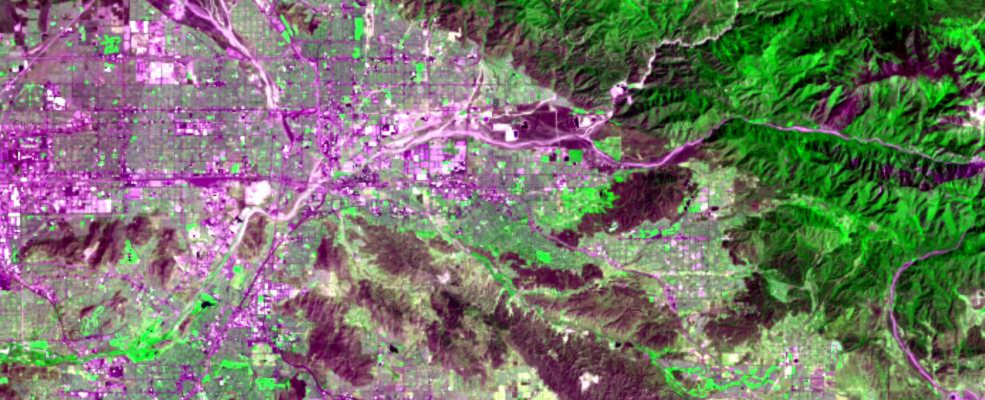

In [45]:
landmap = gis.map('Redlands, CA')
landmap

In [22]:
landmap.add_layer(land_water_lr)

## Visualize the workflow using `draw_graph`

We can take advantage of the `draw_graph` method to verify and present our workflow. This can be very useful when you perform complicated analysis.

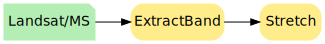

In [23]:
land_water_lr.draw_graph()

## Use case - change detection

Now we are going demonstrate how to use raster function chaining to perform change detection, which is one of the most common tasks in remote sensing. The goal is to compare images of the same area from two different times.

### Get images of two different times of the same area

In [24]:
from arcgis.geocoding import geocode

# get spatial extent of Redlands
area = geocode('Redlands, CA', out_sr=l8_lyr.properties.spatialReference)[0]
area['extent']

{'xmin': -13052832.571464855,
 'ymin': 4026436.3359408537,
 'xmax': -13036579.925809037,
 'ymax': 4046053.3775858423}

Now let's query all landsat layers between 2015 and 2019

In [25]:
import pandas as pd
from datetime import datetime

selected = l8_lyr.filter_by(time=[datetime(2015, 1, 1), datetime(2019, 1, 1)],
                             geometry=arcgis.geometry.filters.intersects(area['extent']))

df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover", 
                    order_by_fields="AcquisitionDate").sdf
df.head()

,AcquisitionDate,CloudCover,GroupName,OBJECTID,SHAPE,Shape_Area,Shape_Length
0,2015-01-04 18:22:11.904000044,0.1037,LC80400362015004LGN00_MTL,84432,"{""rings"": [[[-12860852.2438, 4198630.038500003...",5.248638e+10,917052.740296
1,2015-01-04 18:22:35.790999889,0.0238,LC80400372015004LGN00_MTL,84496,"{""rings"": [[[-12907879.6358, 4005216.699000001...",5.074895e+10,901291.898351
2,2015-01-20 18:22:07.826999903,0.8998,LC80400362015020LGN00_MTL,84433,"{""rings"": [[[-12861361.5129, 4198638.006399997...",5.238693e+10,916794.241228
3,2015-01-20 18:22:31.719000101,0.5907,LC80400372015020LGN00_MTL,84497,"{""rings"": [[[-12908240.5626, 4005219.975599996...",5.078004e+10,901562.429520
4,2015-02-05 18:22:04.519000052,0.0202,LC80400362015036LGN00_MTL,84434,"{""rings"": [[[-12862687.679200001, 4198655.3844...",5.250613e+10,916748.873584


In [26]:
old = l8_lyr.filter_by('OBJECTID=84452')   # 2015-11-20
new = l8_lyr.filter_by('OBJECTID=1028427') # 2018-12-30

### Obtain difference through map algebra

Now I have the images, let's compute the NDVI and get their difference.

Instead of using the `ndvi()` method that applies a fixed raster algebra, let's do this through `BandArithmetic()` method that allows you to perform user-defined map algebra. All you need to do is to specify your own formula.

In [36]:
# ndvi_diff = ndvi(new, '5 4') - ndvi(old, '5 4')
ndvi_old = band_arithmetic(old, "(b5 - b4) / (b5 + b4)")
ndvi_new = band_arithmetic(new, "(b5 - b4) / (b5 + b4)")
ndvi_diff = ndvi_new - ndvi_old

Now we can add the difference image onto a map.


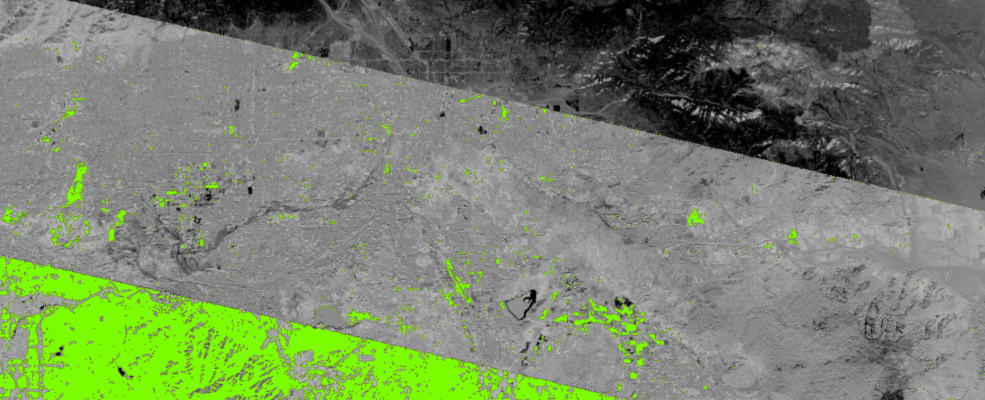

In [46]:
change_map = gis.map('Redlands, CA')
change_map

In [38]:
change_map.add_layer(ndvi_diff)

It's hard to tell which area has changed the most. So let's reclassify it using `remap` and display high increase with the color of green using `colormap`.

In [43]:
threshold_val = 0.2
masked = colormap(remap(ndvi_diff, # assign pixels whose value is greater than 0.2 with 1, and the rest with no_data
                        input_ranges=[threshold_val, 1], 
                        output_values=[1], 
                        no_data_ranges=[-1, threshold_val], astype='u8'), 
                  colormap=[[1, 124, 252, 0]], astype='u8')

In [44]:
change_map.add_layer(masked)

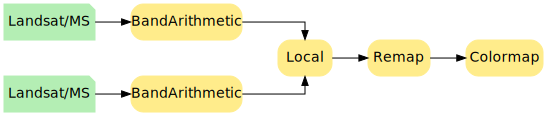

In [32]:
masked.draw_graph()

## Save your result

The `save()` method on ImageryLayer class persists this imagery layer to the GIS as an Imagery Layer item. If `for_viz` parameter is True, a new Item is created that uses the applied raster functions for visualization at display resolution using on-the-fly image processing. If `for_viz` is False, distributed raster analysis is used for generating a new raster information product by applying raster functions at source resolution across the extent of the output imagery layer.


In the example below, the threshold mask is being saved as item for visualization:

In addition to visualizing the imagery layers in the Jupyter Notebook, or using a map widge, they can be exported using the `export_image` method provided by ImageryLayers:

In [33]:
savedimg = ndvi_diff.export_image(bbox=area['extent'], size=[1200,450], f='image', save_folder='.', save_file='img.jpg')
savedimg

'./img.jpg'

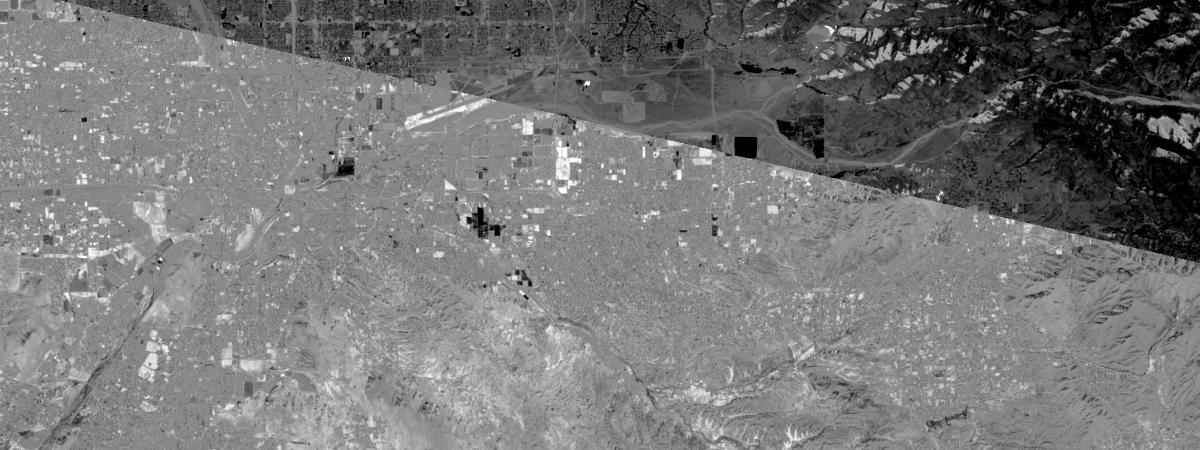

In [34]:
from IPython.display import Image
Image(savedimg)

In [35]:
lyr = masked.save('Test_viz_layer3', for_viz=True)
lyr

<Item title:"Test_viz_layer3" type:Imagery Layer owner:arcgis_python>